In [1]:
###################################################
### This file is part of numsimqubits.          ###
###                                             ###    
### Copyright (c) 2020 and later, Andras Gyenis ###
### All rights reserved.                        ###
###################################################

# Importing packages, modules.

import sys
import numpy as np
sys.path.append('../')

%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.display import display, Image, Markdown

import numsimqubits.dynamics as dyn
from numsimqubits.dynamics.driven_systems import two_level_one_drive, combine_pulses
from matplotlib.ticker import AutoMinorLocator
from qutip import Qobj
import qutip as qt
from scipy.optimize import leastsq
import copy
from tqdm import tqdm

import numsimqubits.qubits.settings as sim_settings
sim_settings.update()

In [28]:
# Define drive object.
pulse_alpha = dyn.Gaussian_pulse(
                                t_0    = 200e-9,                  # The center of the pulse [s].
                                sigma  = 100e-9,                  # The width of the pulse [s].
                                amp    = 10e-3,                    # The amplitude of the pulse [GHz].
                                freq   = 2,                       # The frequency of drive [GHz] 
                                phase  = 0,                       # The phase of the pulse.
                                t_ls   = np.linspace(0,5e-7,201)  # The time axis. 
                               )

# Define drive object.
pulse_square = dyn.Square_pulse(
                                t_0    = 149e-9,                  # The center of the pulse [s].
                                T      = 300e-9,                  # The width of the pulse [s].
                                amp    = 2e-3,                    # The amplitude of the pulse [GHz].
                                freq   = 2,                       # The frequency of drive [GHz] 
                                phase  = 0,                       # The phase of the pulse.
                                t_ls   = np.linspace(0,5e-7,201)  # The time axis.
                               )

# Define the two level system object.
two_level_system = dyn.Atom(
                       N_levels      = 2,                      # The number of energy levels.
                       energies      = [0, 2],               # The energy of the atomic levels [GHz].
                       couplings     = [[0, 1],                # The couplings between energy elevels.
                                        [1,0]],    
                       depolar_rates = [[0, 0],              # The decay between energy levels [GHz]. 
                                        [0, 0]],         
                       dephase_rates = [[0, 0],                # The dephasing between energy levels [GHz].
                                        [0, 0]],
                       initial_state = qt.basis(2,0),          # The initial state of the atom.
                       )


### Driving with square pulse

In [15]:
two_level_system.calculate_dynamics(two_level_one_drive, pulse_square)

<IPython.core.display.Javascript object>


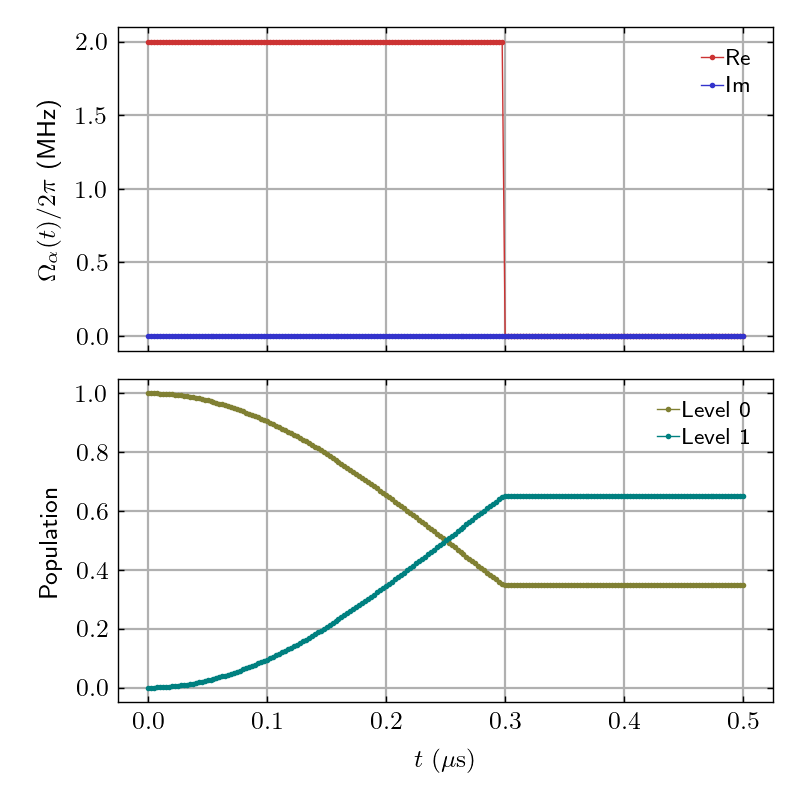

In [16]:
# Plot the pulses and the populations.

t_list = pulse_square.t_ls

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, 
                        gridspec_kw={'height_ratios':[1,1]},
                       figsize=(4,4))

axs[0].plot(t_list * 1e6, pulse_square.I(t_list) / 1e6 / 2 / np.pi, 
            '-o', markersize= 1, linewidth=0.5,
            color=[0.8,0.2,0.2], label = r'Re')
axs[0].plot(t_list * 1e6, pulse_square.Q(t_list) / 1e6 / 2 / np.pi, 
            '-o', markersize= 1, linewidth=0.5,
            color=[0.2,0.2,0.8], label = r'Im')
axs[0].set_ylabel(r"$\Omega_\alpha(t)/2\pi$ (MHz)", labelpad=5)
axs[0].legend(loc='best', fontsize = 8)
axs[0].grid()

axs[1].plot(t_list * 1e6, two_level_system.population[0], '-o', markersize= 1, linewidth=0.5,
            color=[0.5,0.5,0.2], label = r'Level 0')

axs[1].plot(t_list * 1e6, two_level_system.population[1], '-o', markersize= 1, linewidth=0.5,
            color=[0.0,0.5,0.5], label = r'Level 1')

axs[1].set_xlabel(r"$t\ \mathrm{(}\mu \mathrm{s)}$", labelpad=5)
axs[1].set_ylabel("Population", labelpad=5)
axs[1].legend(loc='best', fontsize = 8)
axs[1].grid()

plt.tight_layout()
plt.show()

### Driving with gaussian pulse

In [29]:
two_level_system.calculate_dynamics(two_level_one_drive, pulse_alpha)

<IPython.core.display.Javascript object>


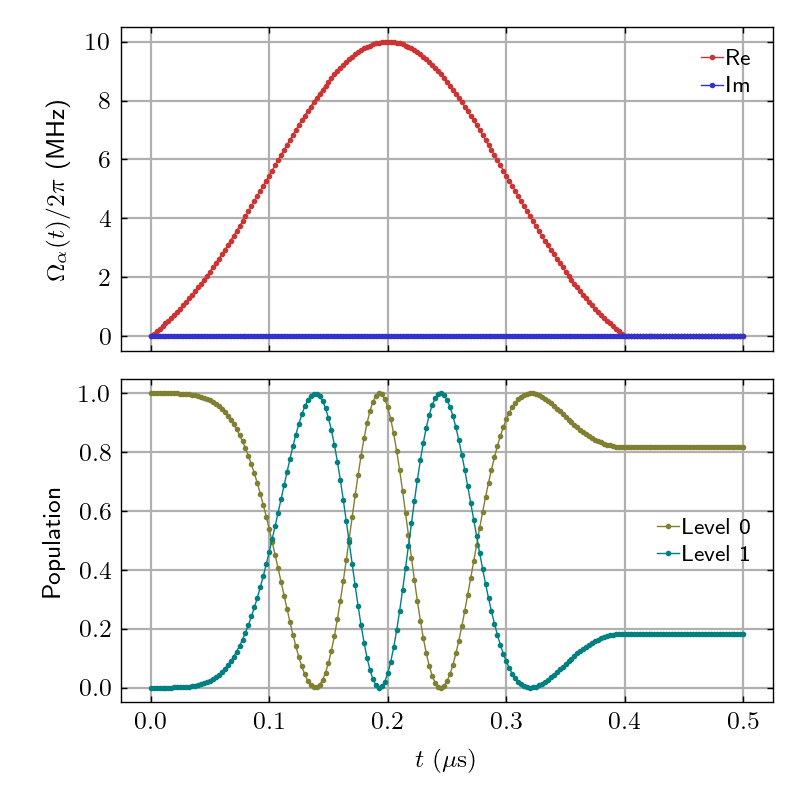

In [30]:
# Plot the pulses and the populations.

t_list = pulse_alpha.t_ls

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, 
                        gridspec_kw={'height_ratios':[1,1]},
                       figsize=(4,4))

axs[0].plot(t_list * 1e6, pulse_alpha.I(t_list) / 1e6 / 2 / np.pi, 
            '-o', markersize= 1, linewidth=0.5,
            color=[0.8,0.2,0.2], label = r'Re')
axs[0].plot(t_list * 1e6, pulse_alpha.Q(t_list) / 1e6 / 2 / np.pi, 
            '-o', markersize= 1, linewidth=0.5,
            color=[0.2,0.2,0.8], label = r'Im')
axs[0].set_ylabel(r"$\Omega_\alpha(t)/2\pi$ (MHz)", labelpad=5)
axs[0].legend(loc='best', fontsize = 8)
axs[0].grid()

axs[1].plot(t_list * 1e6, two_level_system.population[0], '-o', markersize= 1, linewidth=0.5,
            color=[0.5,0.5,0.2], label = r'Level 0')

axs[1].plot(t_list * 1e6, two_level_system.population[1], '-o', markersize= 1, linewidth=0.5,
            color=[0.0,0.5,0.5], label = r'Level 1')

axs[1].set_xlabel(r"$t\ \mathrm{(}\mu \mathrm{s)}$", labelpad=5)
axs[1].set_ylabel("Population", labelpad=5)
axs[1].legend(loc='best', fontsize = 8)
axs[1].grid()

plt.tight_layout()
plt.show()

### Detuning vs amplitude of the drive for square and gaussian pulse

#### Square pulse

In [9]:
delta_ls = np.linspace(-25e-3, 25e-3, 51)
amp_ls   = np.linspace(1e-3, 21e-3, 51)

pulse_square.T   = 200e-9
pulse_square.t_0 = 100e-9

population_mx = np.zeros((len(amp_ls), len(delta_ls)))

for amp_idx, amp in enumerate(amp_ls):
    
    for delta_idx, delta in enumerate(delta_ls):
        
        pulse_square.amp  = amp
        pulse_square.freq = two_level_system.energies[1] - two_level_system.energies[0] + delta
        pulse_square.update_base()
        
        two_level_system.calculate_dynamics(two_level_one_drive, pulse_square)

        population_mx[amp_idx, delta_idx] = two_level_system.population[1][-1]


<IPython.core.display.Javascript object>


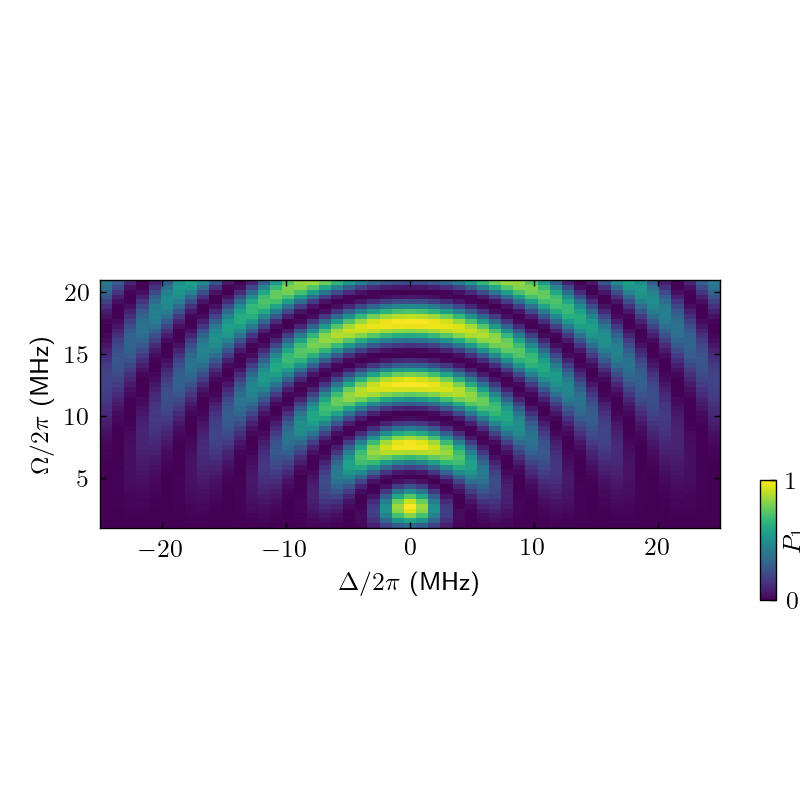

In [10]:
fig, ax = plt.subplots(figsize=(4,4))

im = ax.imshow(np.flipud(population_mx), 
          extent=[delta_ls[0]*1e3, delta_ls[-1]*1e3, amp_ls[0]*1e3, amp_ls[-1]*1e3],
          aspect=1, vmin=0, vmax=1)

ax.set_xlabel(r"$\Delta / 2\pi$ (MHz)")
ax.set_ylabel(r"$\Omega / 2\pi$ (MHz)")

cax = plt.axes([0.95, 0.25, 0.02, 0.15])
cb  = plt.colorbar(im, cax=cax, ticks = [0,1]) 
cb.set_label(r"$P_1$", labelpad=-5)


plt.show()

#### Gaussian pulse

In [11]:
pulse_alpha.sigma = 20e-9
pulse_alpha.t_0   = 40e-9

delta_ls = np.linspace(-25e-3, 25e-3, 51)
amp_ls   = np.linspace(1e-3, 51e-3, 51)

population_mx = np.zeros((len(amp_ls), len(delta_ls)))

for amp_idx, amp in enumerate(amp_ls):
    
    for delta_idx, delta in enumerate(delta_ls):
        
        pulse_alpha.amp  = amp
        pulse_alpha.freq = two_level_system.energies[1] - two_level_system.energies[0] + delta
        pulse_alpha.update_base()
        
        two_level_system.calculate_dynamics(two_level_one_drive, pulse_alpha)
        
        population_mx[amp_idx, delta_idx] = two_level_system.population[1][-1]


<IPython.core.display.Javascript object>


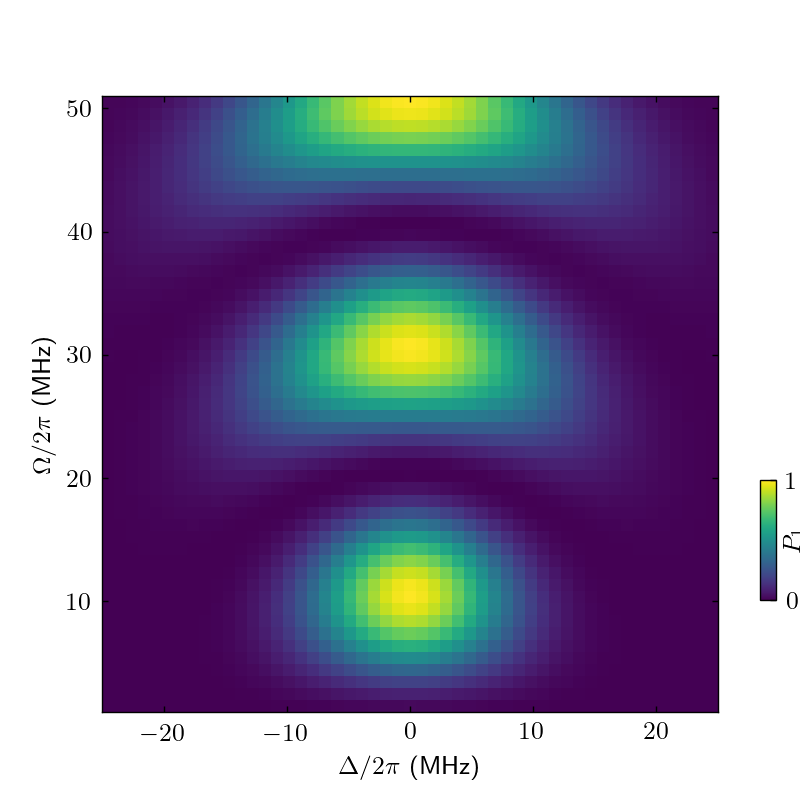

In [12]:
fig, ax = plt.subplots(figsize=(4,4))

im = ax.imshow(np.flipud(population_mx), 
          extent=[delta_ls[0]*1e3, delta_ls[-1]*1e3, amp_ls[0]*1e3, amp_ls[-1]*1e3],
          aspect=1, vmin=0, vmax=1)

ax.set_xlabel(r"$\Delta / 2\pi$ (MHz)")
ax.set_ylabel(r"$\Omega / 2\pi$ (MHz)")

cax = plt.axes([0.95, 0.25, 0.02, 0.15])
cb  = plt.colorbar(im, cax=cax, ticks = [0,1]) 
cb.set_label(r"$P_1$", labelpad=-5)


plt.show()

### Detuning vs length of the drive for square and gaussian pulse

#### Square pulse

In [14]:
delta_ls  = np.linspace(-25e-3, 25e-3, 51)
length_ls = np.linspace(10e-9, 210e-9, 51)

pulse_square.amp = 15e-3

population_mx = np.zeros((len(length_ls), len(delta_ls)))

for length_idx, length in enumerate(length_ls):
    
    for delta_idx, delta in enumerate(delta_ls):
        
        pulse_square.t_0  = length / 2
        pulse_square.T    = length
        pulse_square.freq = two_level_system.energies[1] - two_level_system.energies[0] + delta_ls[delta_idx]
        pulse_square.update_base()
        
        two_level_system.calculate_dynamics(two_level_one_drive, pulse_square)
        population_mx[length_idx, delta_idx] = two_level_system.population[1][-1]

<IPython.core.display.Javascript object>


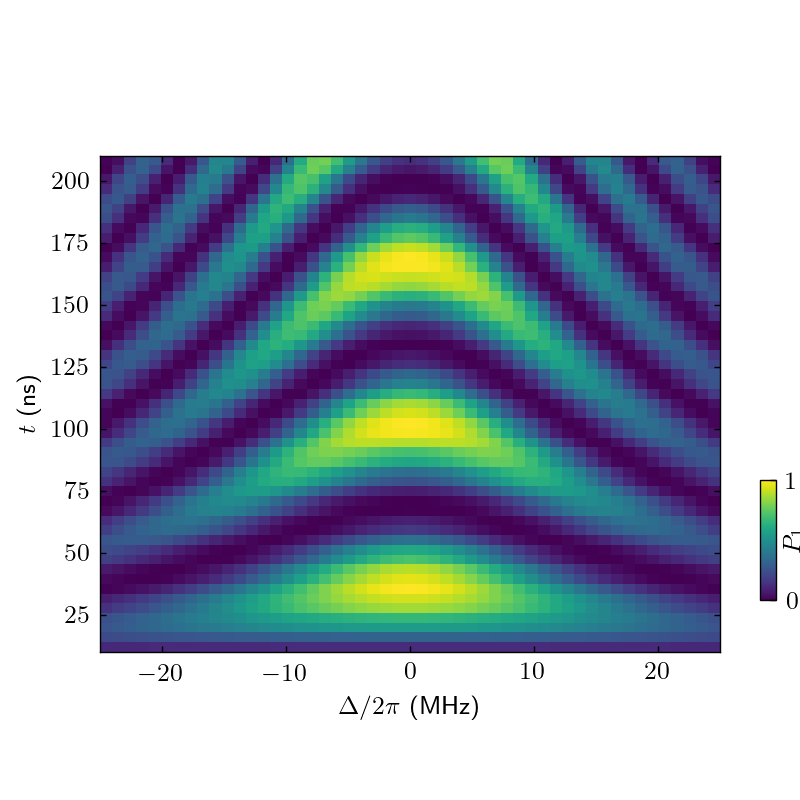

In [16]:
fig, ax = plt.subplots(figsize=(4,4))

im = ax.imshow(np.flipud(population_mx), 
          extent=[delta_ls[0]*1e3, delta_ls[-1]*1e3, length_ls[0]*1e9, length_ls[-1]*1e9],
          aspect=0.2, vmin=0, vmax=1)

ax.set_xlabel(r"$\Delta / 2\pi$ (MHz)")
ax.set_ylabel(r"$t$ (ns)")

cax = plt.axes([0.95, 0.25, 0.02, 0.15])
cb  = plt.colorbar(im, cax=cax, ticks = [0,1]) 
cb.set_label(r"$P_1$", labelpad=-5)


plt.show()

#### Gaussian pulse

In [18]:
delta_ls  = np.linspace(-25e-3, 25e-3, 51)
length_ls = np.linspace(10e-9, 210e-9, 51)

pulse_alpha.amp = 25e-3

population_mx = np.zeros((len(length_ls), len(delta_ls)))

for length_idx, length in enumerate(length_ls):
    
    for delta_idx, delta in enumerate(delta_ls):
        
        pulse_alpha.t_0   = length / 2
        pulse_alpha.sigma = length / 4
        pulse_alpha.freq  = two_level_system.energies[1] - two_level_system.energies[0] + delta_ls[delta_idx]
        pulse_alpha.update_base()
        
        two_level_system.calculate_dynamics(two_level_one_drive, pulse_alpha)
        population_mx[length_idx, delta_idx] = two_level_system.population[1][-1]

<IPython.core.display.Javascript object>


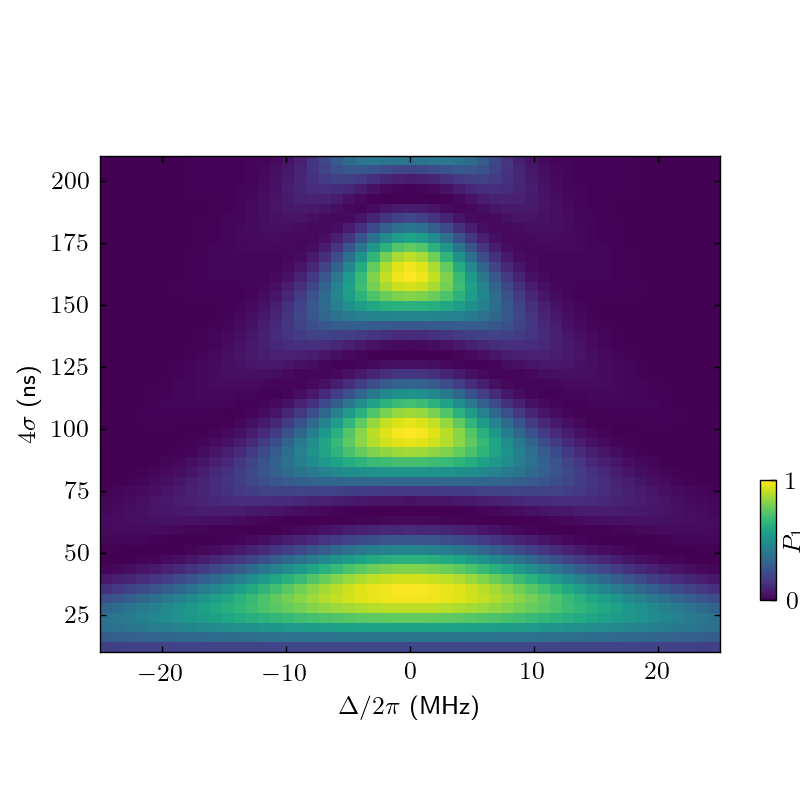

In [19]:
fig, ax = plt.subplots(figsize=(4,4))

im = ax.imshow(np.flipud(population_mx), 
          extent=[delta_ls[0]*1e3, delta_ls[-1]*1e3, length_ls[0]*1e9, length_ls[-1]*1e9],
          aspect=0.2, vmin=0, vmax=1)

ax.set_xlabel(r"$\Delta / 2\pi$ (MHz)")
ax.set_ylabel(r"$4\sigma$ (ns)")

cax = plt.axes([0.95, 0.25, 0.02, 0.15])
cb  = plt.colorbar(im, cax=cax, ticks = [0,1]) 
cb.set_label(r"$P_1$", labelpad=-5)


plt.show()

### Amplitude vs length of the drive for square and gaussian pulse

#### Square pulse

In [20]:
amp_ls    = np.linspace(1e-3, 21e-3, 51)
length_ls = np.linspace(10e-9, 210e-9, 51)

pulse_square.freq = two_level_system.energies[1]

population_mx = np.zeros((len(length_ls), len(amp_ls)))

for length_idx, length in enumerate(length_ls):
    
    for amp_idx, amp in enumerate(amp_ls):
        
        pulse_square.t_0  = length / 2
        pulse_square.T    = length
        pulse_square.amp  = amp
        pulse_square.update_base()
        
        two_level_system.calculate_dynamics(two_level_one_drive, pulse_square)
        population_mx[length_idx, amp_idx] = two_level_system.population[1][-1]

<IPython.core.display.Javascript object>


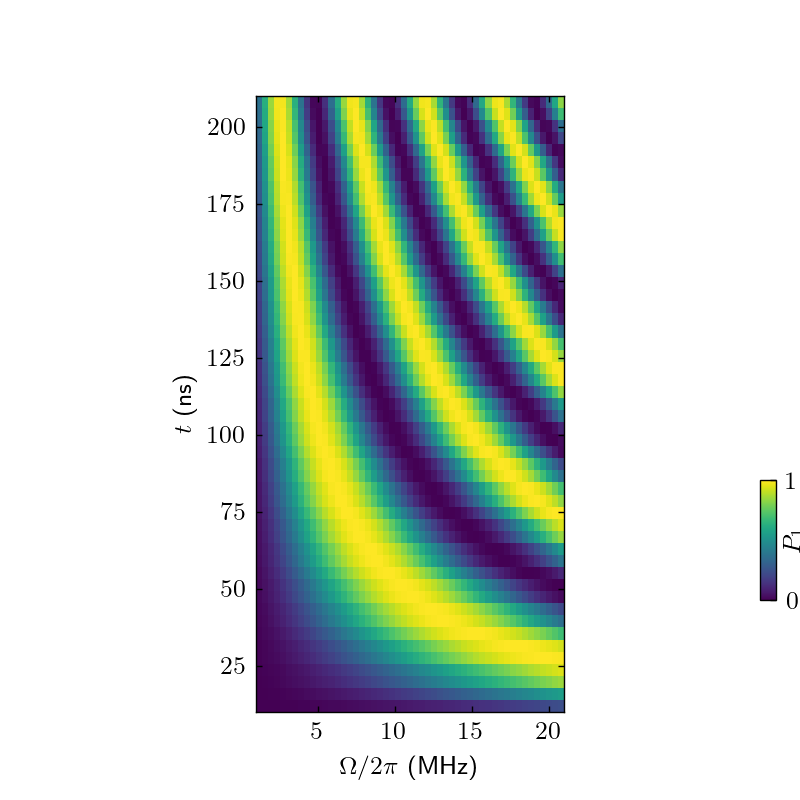

In [21]:
fig, ax = plt.subplots(figsize=(4,4))

im = ax.imshow(np.flipud(population_mx), 
          extent=[amp_ls[0]*1e3, amp_ls[-1]*1e3, length_ls[0]*1e9, length_ls[-1]*1e9],
          aspect=0.2, vmin=0, vmax=1)

ax.set_xlabel(r"$\Omega / 2\pi$ (MHz)")
ax.set_ylabel(r"$t$ (ns)")

cax = plt.axes([0.95, 0.25, 0.02, 0.15])
cb  = plt.colorbar(im, cax=cax, ticks = [0,1]) 
cb.set_label(r"$P_1$", labelpad=-5)


plt.show()

#### Gaussian pulse

In [22]:
amp_ls    = np.linspace(1e-3, 21e-3, 51)
length_ls = np.linspace(10e-9, 210e-9, 51)

pulse_alpha.freq = two_level_system.energies[1]

population_mx = np.zeros((len(length_ls), len(amp_ls)))

for length_idx, length in enumerate(length_ls):
    
    for amp_idx, amp in enumerate(amp_ls):
        
        pulse_alpha.t_0   = length / 2
        pulse_alpha.sigma = length / 4
        pulse_alpha.amp   = amp
        pulse_alpha.update_base()        
        
        two_level_system.calculate_dynamics(two_level_one_drive, pulse_alpha)
        population_mx[length_idx, amp_idx] = two_level_system.population[1][-1]

<IPython.core.display.Javascript object>


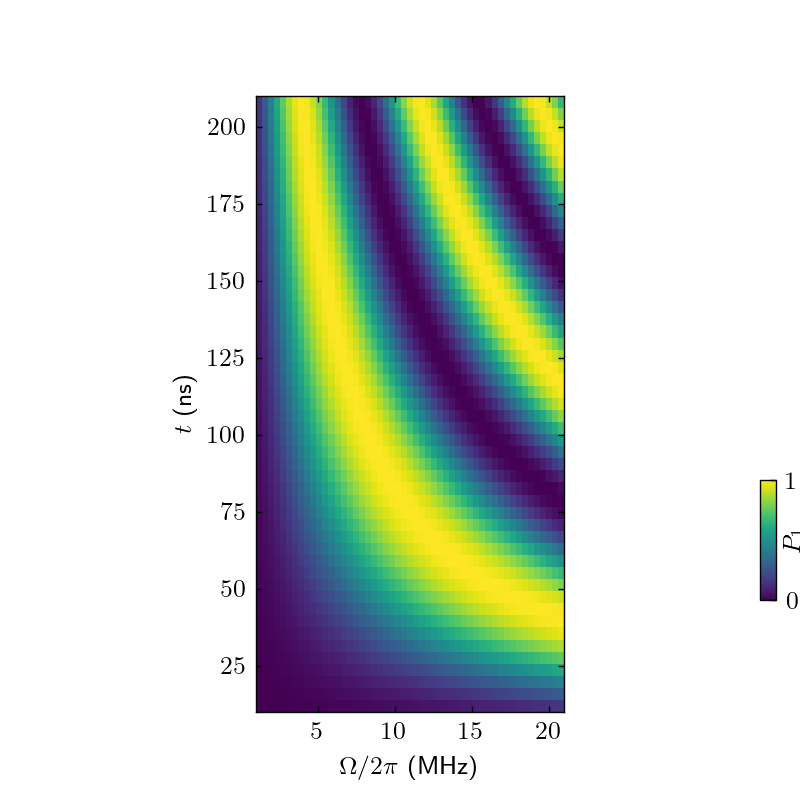

In [23]:
fig, ax = plt.subplots(figsize=(4,4))

im = ax.imshow(np.flipud(population_mx), 
          extent=[amp_ls[0]*1e3, amp_ls[-1]*1e3, length_ls[0]*1e9, length_ls[-1]*1e9],
          aspect=0.2, vmin=0, vmax=1)

ax.set_xlabel(r"$\Omega / 2\pi$ (MHz)")
ax.set_ylabel(r"$t$ (ns)")

cax = plt.axes([0.95, 0.25, 0.02, 0.15])
cb  = plt.colorbar(im, cax=cax, ticks = [0,1]) 
cb.set_label(r"$P_1$", labelpad=-5)


plt.show()

### Coherence properties

In [36]:
# Fit & error functions
def T1_fit(delay, params):
    T1          = params[0]
    amplitude   = params[1]
    offset      = params[2]
    return amplitude * np.exp(- delay / T1) + offset

def T1_error_function(params, delay, data):
    return data - T1_fit(delay, params)

# T2 Ramsey fit
def T2R_fit(delay, params):
    T2R         = params[0]
    amplitude   = params[1]
    delta       = params[2]
    phi0        = params[3]
    offset      = params[4]
    return amplitude * np.exp(- delay / T2R) * np.cos(2 * np.pi * delta * delay + phi0) + offset

def T2R_error_function(params, delay, data):
    return data - T2R_fit(delay, params)


### Energy decay measurement

In [63]:
# Define drive object.
pulse_alpha = dyn.Gaussian_pulse(
                                t_0    = 100e-9,                     # The center of the pulse [s].
                                sigma  = 50e-9,                      # The width of the pulse [s].
                                amp    = 5e-3,                       # The amplitude of the pulse [GHz].
                                freq   = 2,                          # The frequency of drive [GHz] 
                                phase  = 0,                          # The phase of the pulse.
                                t_ls   = np.linspace(0,20e-7,201)    # The time axis. 
                               )


# Define the two level system object.
two_level_system = dyn.Atom(
                       N_levels      = 2,                      # The number of energy levels.
                       energies      = [0, 2],               # The energy of the atomic levels [GHz].
                       couplings     = [[0, 1],                # The couplings between energy elevels.
                                        [1,0]],    
                       depolar_rates = [[0, 0],              # The decay between energy levels [GHz]. 
                                        [5e-4/2/np.pi, 0]],         
                       dephase_rates = [[0, 0],                # The dephasing between energy levels [GHz].
                                        [0, 0]],
                       initial_state = qt.basis(2,0),          # The initial state of the atom.
                      )

pulse_alpha.update_base()   
two_level_system.calculate_dynamics(two_level_one_drive, pulse_alpha)

<IPython.core.display.Javascript object>


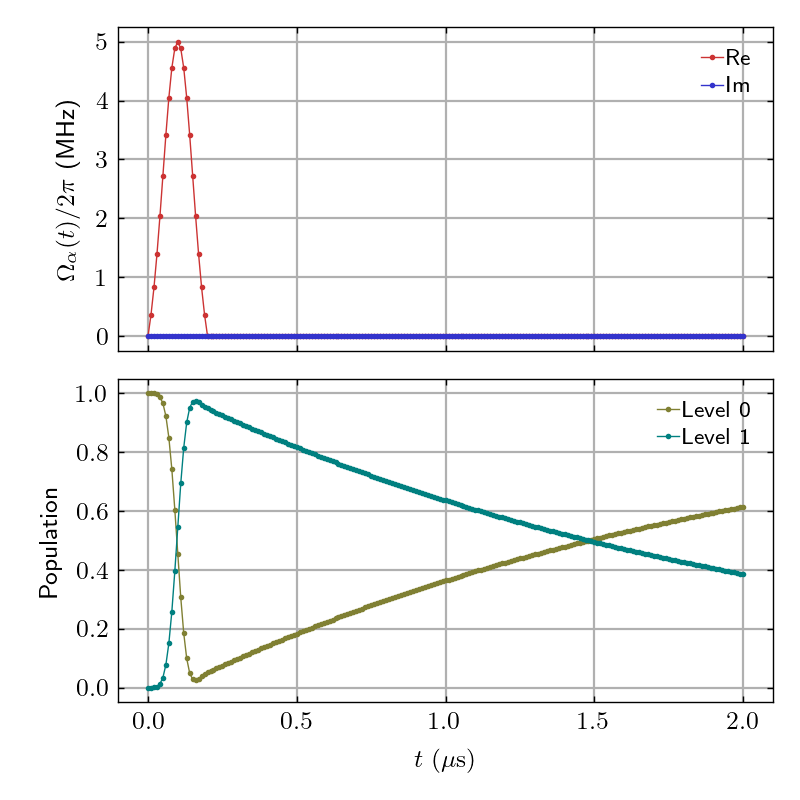

In [64]:
# Plot the pulses and the populations.

t_list = pulse_alpha.t_ls

fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, 
                        gridspec_kw={'height_ratios':[1,1]},
                       figsize=(4,4))

axs[0].plot(t_list * 1e6, pulse_alpha.I(t_list) / 1e6 / 2 / np.pi, 
            '-o', markersize= 1, linewidth=0.5,
            color=[0.8,0.2,0.2], label = r'Re')
axs[0].plot(t_list * 1e6, pulse_alpha.Q(t_list) / 1e6 / 2 / np.pi, 
            '-o', markersize= 1, linewidth=0.5,
            color=[0.2,0.2,0.8], label = r'Im')
axs[0].set_ylabel(r"$\Omega_\alpha(t)/2\pi$ (MHz)", labelpad=5)
axs[0].legend(loc='best', fontsize = 8)
axs[0].grid()

axs[1].plot(t_list * 1e6, two_level_system.population[0], '-o', markersize= 1, linewidth=0.5,
            color=[0.5,0.5,0.2], label = r'Level 0')

axs[1].plot(t_list * 1e6, two_level_system.population[1], '-o', markersize= 1, linewidth=0.5,
            color=[0.0,0.5,0.5], label = r'Level 1')

axs[1].set_xlabel(r"$t\ \mathrm{(}\mu \mathrm{s)}$", labelpad=5)
axs[1].set_ylabel("Population", labelpad=5)
axs[1].legend(loc='best', fontsize = 8)
axs[1].grid()

plt.tight_layout()
plt.show()

$T_{1} = $ 2.00 $\mu$s

$AMP = $ 1.048 

$Offset = $ -0.000 

$T_{1}^\mathrm{expected} = $ 2.00 $\mu$s

<IPython.core.display.Javascript object>


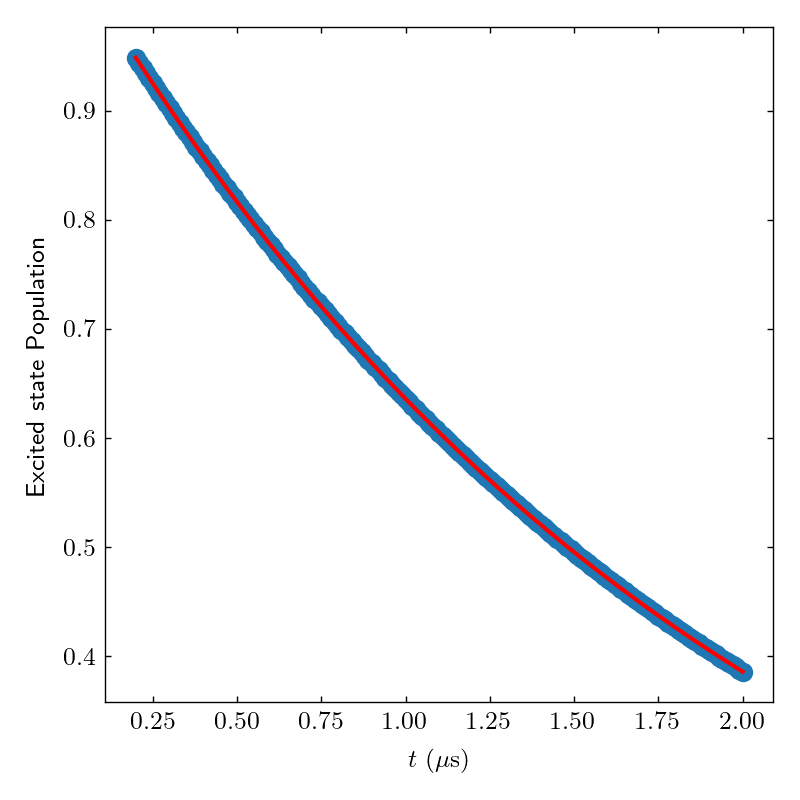

In [65]:
# Fit T1 decay

t_pulse_end = pulse_alpha.t_0 + 2 * pulse_alpha.sigma
t_idx = np.argmin(np.abs(t_list - t_pulse_end))
t_T1 = t_list[t_idx:] * 1e6
p_T1 = two_level_system.population[1][t_idx:]

T1_theory = 1e-3 / two_level_system.depolar_rates[1][0] / 2 / np.pi

initial_params = np.zeros(3)
initial_params[0] = 1 
initial_params[1] = 1
initial_params[2] = 0

fit_params, success = leastsq(T1_error_function, initial_params, args = (t_T1, p_T1))

display(Markdown('$T_{1} = $ %.2f $\mu$s' % (fit_params[0])))
display(Markdown('$AMP = $ %.3f ' % (fit_params[1])))
display(Markdown('$Offset = $ %.3f ' % (fit_params[2])))
display(Markdown('$T_{1}^\mathrm{expected} = $ %.2f $\mu$s' % (T1_theory)))

fig = plt.figure(figsize=(4,4))
ax  = fig.add_subplot(111)
ax.plot(t_T1, p_T1, 'o')
ax.plot(t_T1, T1_fit(t_T1, fit_params), '-r')
ax.set_xlabel(r"$t\ \mathrm{(}\mu \mathrm{s)}$", labelpad=5)
ax.set_ylabel("Excited state Population", labelpad=5)

plt.tight_layout()
plt.show()

### Ramsey measurement

In [38]:
# Define drive object.
pulse_alpha = dyn.Gaussian_pulse(
                                t_0    = 100e-9,                     # The center of the pulse [s].
                                sigma  = 50e-9,                      # The width of the pulse [s].
                                amp    = 2.4e-3,                       # The amplitude of the pulse [GHz].
                                freq   = 2,                          # The frequency of drive [GHz] 
                                phase  = 0,                          # The phase of the pulse.
                                t_ls   = np.linspace(0,20e-7,201)    # The time axis. 
                               )

pulse_beta = copy.deepcopy(pulse_alpha) # create the second pulse

# Define the two level system object.
two_level_system = dyn.Atom(
                       N_levels      = 2,                      # The number of energy levels.
                       energies      = [0, 2],               # The energy of the atomic levels [GHz].
                       couplings     = [[0, 1],                # The couplings between energy elevels.
                                        [1,0]],    
                       depolar_rates = [[0, 0],              # The decay between energy levels [GHz]. 
                                        [2e-9, 0]],         
                       dephase_rates = [[0, 0],                # The dephasing between energy levels [GHz].
                                        [0, 1e-3/2/np.pi]],
                       initial_state = qt.basis(2,0),          # The initial state of the atom.
                      )

 

In [39]:
delay_list = np.linspace(0, 0.5e-6, 201)
delta_frequency = 10e6
t_T2R = delay_list * 1e6
t_list = pulse_alpha.t_ls

p_T2R = []

for delay in tqdm(delay_list):
    
    pulse_beta.t_0   = pulse_alpha.t_0 + delay
    pulse_beta.phase = 2 * np.pi * delta_frequency * delay
    t_ls_end = pulse_beta.t_0 + 2 * pulse_beta.sigma
    t_ls_idx = np.argmin(np.abs(t_ls_end - t_list))
    
    pulse_beta.update_base()
    Ramsey_pulse = combine_pulses(pulse_alpha, pulse_beta)
    
    two_level_system.calculate_dynamics(two_level_one_drive, Ramsey_pulse)
    
    p_T2R.append(two_level_system.population[1][t_ls_idx])


100%|██████████| 201/201 [00:05<00:00, 39.10it/s]


$T_{2R} = $ 1.03 $\mu$s

$AMP = $ 0.493 

$\Delta = $ 10.065 MHz 

$\Phi_0 = $ -0.129 

$Offset = $ 0.514 

$T_{2R}^\mathrm{expected} = $ 1.00 $\mu$s

<IPython.core.display.Javascript object>


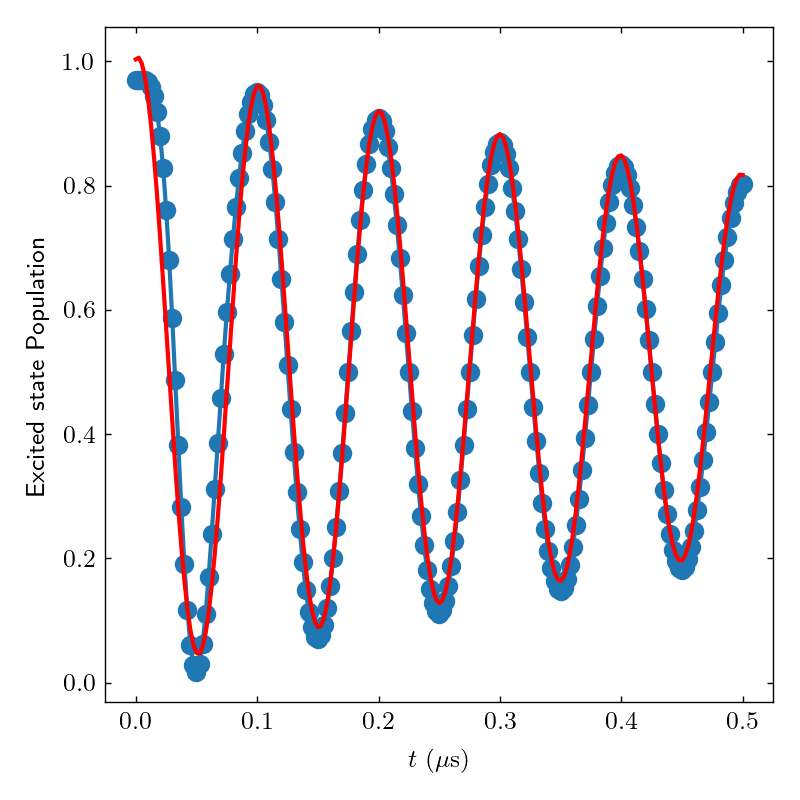

In [40]:
# Expected T2R

T1_theory    = 1e-3 / two_level_system.depolar_rates[1][0] / 2 / np.pi
T_phi_theory = 1e-3 / two_level_system.dephase_rates[1][1] / 2 / np.pi
T2R_theory = 1 / (1 / T1_theory / 2 + 1 / T_phi_theory) 

# Fit T2R decay
initial_params = np.zeros(5)
initial_params[0] = 1 
initial_params[1] = 1
initial_params[2] = 10
initial_params[3] = 0
initial_params[4] = 0.5

fit_params, success = leastsq(T2R_error_function, initial_params, args = (t_T2R, p_T2R))

display(Markdown('$T_{2R} = $ %.2f $\mu$s' % (fit_params[0])))
display(Markdown('$AMP = $ %.3f ' % (fit_params[1])))
display(Markdown('$\Delta = $ %.3f MHz ' % (fit_params[2])))
display(Markdown('$\Phi_0 = $ %.3f ' % (fit_params[3])))
display(Markdown('$Offset = $ %.3f ' % (fit_params[4])))
display(Markdown('$T_{2R}^\mathrm{expected} = $ %.2f $\mu$s' % (T2R_theory)))


fig = plt.figure(figsize=(4,4))
ax  = fig.add_subplot(111)
ax.plot(t_T2R, p_T2R, '-o')
ax.plot(t_T2R, T2R_fit(t_T2R, fit_params), '-r')
ax.set_xlabel(r"$t\ \mathrm{(}\mu \mathrm{s)}$", labelpad=5)
ax.set_ylabel("Excited state Population", labelpad=5)

plt.tight_layout()
plt.show()

In [9]:
two_level_system.dephase_rates[0][0] 

0.0002